In [1]:
import skimage
import skimage.io
import skimage.transform
import os
import numpy as np
import utils
import matplotlib.pyplot as plt

In [3]:
def magnitude(fft_im):
    real = fft_im.real
    imag = fft_im.imag
    return np.sqrt(real**2 + imag**2)

    
def create_low_pass_frequency_kernel(im: np.array,
                                      radius: int):
    center_col = im.shape[1] // 2
    center_row = im.shape[0] // 2
    assert len(im.shape) == 2,\
        "Expected a grayscale image. Got image shape: {}".format(im.shape)
    kernel = np.ones_like((im))
    rr, cc = skimage.draw.circle(center_row, center_col, radius)
    kernel[rr, cc] = 0.0
    kernel = np.fft.fftshift(kernel)
    return 1 - kernel

def convolve_im(im: np.array,
                kernel: np.array):
    """ Convolves the image (im) with the spatial kernel (kernel),
        and returns the resulting image.

        "verbose" can be used for turning on/off visualization
        convolution

        Note: kernel can be of different shape than im.

    Args:
        im: np.array of shape [H, W]
        kernel: np.array of shape [K, K] 
    Returns:
        im: np.array of shape [H, W]
    """
    # START YOUR CODE HERE ### (You can change anything inside this block)

    im_fft = np.fft.fft2(im)
    padded_kernel = np.pad(kernel, ((
        0, im.shape[0]-kernel.shape[0]), (0, im.shape[1]-kernel.shape[1])), 'constant') # Add zero-padding to kernel
    fft_kernel = np.fft.fft2(padded_kernel) # Compute fft of kernel
    conv_fft = im_fft * fft_kernel # Use convolution theorem
    conv_result = np.fft.ifft2(conv_fft).real # Inverse Fourier to get image in spatial domain

    return conv_result

gaussian_kernel = np.array([
        [1, 4, 6, 4, 1],
        [4, 16, 24, 16, 4],
        [6, 24, 36, 24, 6],
        [4, 16, 24, 16, 4],
        [1, 4, 6, 4, 1],
    ]) / 256

# Cleaning the moon

Let's investigate the moon image in both spatial and frequency domain.

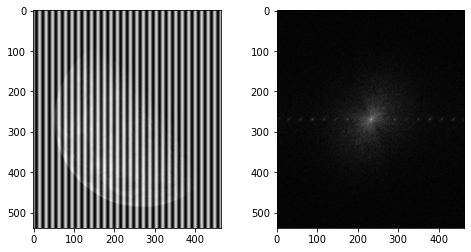

In [4]:
impath = os.path.join("images", "noisy_moon.png")
im = utils.read_im(impath)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(im, cmap="gray")
plt.subplot(1, 2, 2)
fft = np.fft.fft2(im)
shifted = np.fft.fftshift(fft)
plt.imshow(np.log1p(magnitude(shifted)), cmap="gray")

In [71]:
im.shape

(538, 464)

The horizontal line of dots in the frequency domain corresponds to the noisy vertical lines in the image. 
There appear to be 8 spikes in the frequency domain one each side of the DC component. This divides the image in to 16 sections. The width of the image is 464, so we will try setting every  $464/16 = 29th$ pixel to 0 along the horizontal line going through the DC component. We make a mask that we can multiply with the image in the frequency domain to attempt to remove the spikes.

C:\Users\joste\AppData\Local\Temp/ipykernel_14472/2790331266.py:5: FutureWarning: `draw.circle` is deprecated in favor of `draw.disk`.`draw.circle` will be removed in version 0.19
  rr, cc = skimage.draw.circle(int(538/2), i, size)


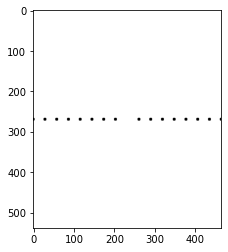

In [33]:
size = 4
mask = np.ones((538, 464))
for i in range(0, 464, 29):
    if i != 8*29:
        rr, cc = skimage.draw.circle(int(538/2), i, size)
        mask[rr, cc] = 0


plt.imshow(mask, cmap="gray")

We apply this filter to the shifted image in the frequency-domain, and do an inverse shift and inverse fft to restore the image.

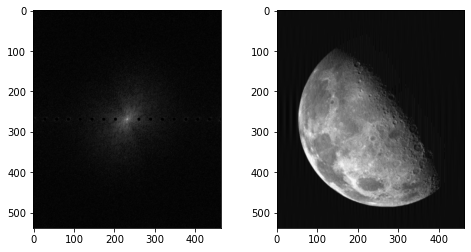

In [32]:
fft_filtered = mask * shifted
fft_filtered_vis = np.log1p(magnitude(fft_filtered))

restored_im = np.fft.ifft2(np.fft.ifftshift(fft_filtered)).real

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(fft_filtered_vis, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(restored_im, cmap="gray")

This worked surprisingly well, even with only 1 pixel wide covers! Increasing the radius to 4 removes most of the remains from the original stripes, wo we will use that.

In [34]:
if __name__ == "__main__":
    # DO NOT CHANGE
    impath = os.path.join("images", "noisy_moon.png")
    im = utils.read_im(impath)

    ### START YOUR CODE HERE ### (You can change anything inside this block)
    
    
    fft = np.fft.fft2(im)
    shifted = np.fft.fftshift(fft)

    fft_filtered = mask * shifted
    fft_filtered_vis = np.log1p(magnitude(fft_filtered))

    restored_im = np.fft.ifft2(np.fft.ifftshift(fft_filtered)).real

    im_filtered = restored_im
    ### END YOUR CODE HERE ###
    utils.save_im("moon_filtered.png", utils.normalize(im_filtered))

Saving image to: image_processed\moon_filtered.png
